# Realistic lightcurves of ellipsoids

This notebook demonstrates how to generate lightcurves within `sorcha`,
under the assumption that the Solar System Objects (SSOs) are simple tri-axial ellipsoids, defined 
by 
$ a \ge b \ge c$,
in simple short-axis rotation mode.

Compared to the ``Ellipsoidal_Lightcurve`` model, the projected surface of the ellipsoid accounts for the non-illuminated part: the model is therefore more accurate but requires more informations (the coordiantes of the target in heliocentric frame) and computation.

In [2]:
import numpy as np
import pandas as pd

import rocks
import requests

import astropy.units as u
from astropy.coordinates import SkyCoord

from sorcha.modules.PPCalculateApparentMagnitudeInFilter import (
    PPCalculateApparentMagnitudeInFilter,
)

import matplotlib.pyplot as plt

# Constants
au = 1.495978707e8  # AU in km
c = 299792458  # m/s
c_AUperDay = c * (1000 / au) * 86400.0

/home/bcarry/anaconda3/envs/sorcha/lib/python3.11/site-packages/assist/__init__.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Lightweight ephemeris function

We will need to compute ephemerides, so let's query the [Miriade](https://ssp.imcce.fr/webservices/miriade/) Virtual Observatory Web service.

In [3]:
def ephemcc(ident, ep, nbd=None, step=None, observer="500", rplane="1", tcoor=5, output=None):
    """Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    """

    # ------
    # Miriade URL
    url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php"

    # Query parameters
    params = {
        "-name": f"{ident}",
        "-mime": "json",
        "-rplane": rplane,
        "-tcoor": tcoor,
        "-output": "--jd",
        "-observer": observer,
        "-tscale": "UTC",
    }

    if "output" in locals():
        params["-output"] += "," + output

    # Single epoch of computation
    if type(ep) != list:
        # Set parameters
        params["-ep"] = ep
        if nbd != None:
            params["-nbd"] = nbd
        if step != None:
            params["-step"] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False

    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {"epochs": ("epochs", "\n".join(["%.6f" % epoch for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=50)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j["data"])
    except KeyError:
        return False

    return ephem

## Definition of simulation

We first define the epochs of the simulation: starting date (expressed in JD), the number of epochs to simulate, and time step between each (in days).

In [4]:
# Choice of time frame
jd0 = 2461131.5  # Start date: here set to 2026-04-01
nbd = 600  # Number of epochs
step = 0.3  # Time step between epochs (days)

We then define the target. It can be an asteroid name/designation or number.
The absolute magnitude and spin properties (coordinates and period) are then retrieved from [SsODNet](https://ssp.imcce.fr/webservices/ssodnet/) (see [Berthier et al., 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract)). Alternatively, you can define all parameters by hand:

- ``H`` the absolute magnitude
- ``ra0`` the right ascension of the spin coordinates (equatorial frame, in degrees) 
- ``dec0`` the declination of the spin coordinates (equatorial frame, in degrees) 
- ``period`` the sidereal rotation period (in hour) 
- ``G1`` and ``G2`` the phase curve coefficients
- ``a_b`` the ratio of equatorial diameters (_a_ and _b_)
- ``a_c`` the ratio between the longest (equatorial) diameter (_a_) and the polar diameter (_c_)

In [5]:
# Target
sso = 594913

# Retrieve the target properties from SsODNet
sc = rocks.Rock(sso)
H = sc.H.value
ra0 = 240.
dec0 = +30. 
period = 6. / 24.0

# Arbitrary phase function and shape
G1 = 0.62
G2 = 0.14
a_b = 1.
a_c = 1.

In [6]:
H

16.22

In [44]:
# Generate ephemerides
# We use here a special output from Miriade, dedicated to this kind of photometric modeling
eph = ephemcc(
    sso,
    ep=jd0,
    nbd=nbd,
    step=step,
    tcoor=5,
    observer="X05",
    output="-- iofile(ephemcc-photom.xml),--lighttime",
)

In [45]:
# Build the observations dataframe
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": eph.Date.values,
        "H_filter": H * np.ones(nbd),
        "G1": G1 * np.ones(nbd),
        "G2": G2 * np.ones(nbd),
        "RA_deg": eph.RA.values,
        "Dec_deg": eph.DEC.values,
        "RA_s_deg": eph.RA_h.values,
        "Dec_s_deg": eph.DEC_h.values,
        "Period": period * np.ones(nbd),
        "Time0": jd0 * np.ones(nbd),
        "phi0": np.radians(0) * np.ones(nbd),
        "RA0": np.radians(ra0) * np.ones(nbd),
        "Dec0": np.radians(dec0) * np.ones(nbd),
        "Period": period * np.ones(nbd),
        "a/b": a_b * np.ones(nbd),
        "a/c": a_c * np.ones(nbd),
        "Range_LTC_km": eph.Dobs.values * au,
        "Obj_Sun_LTC_km": eph.Dhelio.values * au,
        "phase_deg": eph.Phase.values,
    }
)

observations_df

,fieldMJD_TAI,H_filter,G1,G2,RA_deg,Dec_deg,RA_s_deg,Dec_s_deg,Period,Time0,phi0,RA0,Dec0,a/b,a/c,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,2461131.5,16.22,0.62,0.14,27.822088,17.985935,67.429127,36.408378,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.070649e+08,8.875918e+07,39.373661
1,2461131.8,16.22,0.62,0.14,28.175932,18.145665,68.168634,36.573875,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.066310e+08,8.860001e+07,39.624571
2,2461132.1,16.22,0.62,0.14,28.529244,18.305692,68.913962,36.735357,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.061803e+08,8.843981e+07,39.878110
3,2461132.4,16.22,0.62,0.14,28.879940,18.464063,69.665117,36.892735,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.057339e+08,8.827857e+07,40.137045
4,2461132.7,16.22,0.62,0.14,29.234868,18.620757,70.422102,37.045916,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.052917e+08,8.811632e+07,40.396146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2461310.0,16.22,0.62,0.14,172.457879,7.502694,148.380198,24.826803,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.095693e+08,7.272794e+07,28.795338
596,2461310.3,16.22,0.62,0.14,172.882857,7.239901,149.241283,24.345076,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.098127e+08,7.257940e+07,28.368367
597,2461310.6,16.22,0.62,0.14,173.310885,6.975770,150.099279,23.856534,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.100627e+08,7.243269e+07,27.941013
598,2461310.9,16.22,0.62,0.14,173.740461,6.711063,150.954220,23.361275,0.25,2461131.5,0.0,4.18879,0.523599,1.0,1.0,2.102965e+08,7.228787e+07,27.511673


## SORCHA simulation

We first simply compute the apparent magnitude, using the
$H G_1 G_2$ formalism, as a baseline.

In [46]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG1G2", "r", "HG1G2_mag")

We then load the lightcurve methods of ``SORCHA`` add-ons:

In [47]:
from sorcha.lightcurves.lightcurve_registration import LC_METHODS, update_lc_subclasses

update_lc_subclasses()
print("Lightcurve methods: " + ", ".join(LC_METHODS))

Lightcurve methods: identity, sinusoidal, ellipsoidal, ellipsoidalwithterminator


We can now compute the apparent magnitude **with** the lightcurve effect (using the
$H G_1 G_2$ formalism for consistency).

In [48]:
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LC_HG1G2_mag", "ellipsoidal"
)

observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LCwT_HG1G2_mag", "ellipsoidalwithterminator"
)

## Graphics illustrating the lightcurve effect

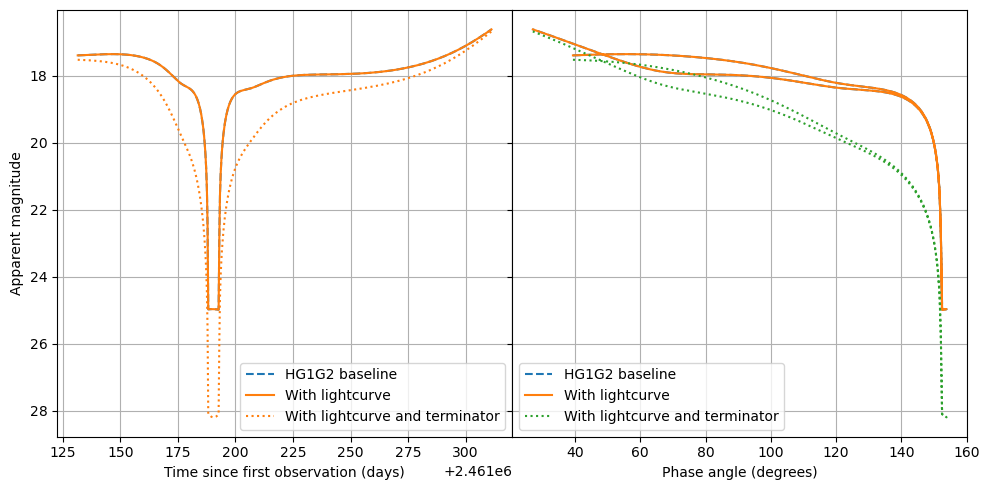

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0})

# --------------------------------------------------------------------------------
# Apparent magnitude vs time
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C1",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Apparent magnitude vs phase
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"],
    linestyle="dotted",
    color="C2",
    label="With lightcurve and terminator",
)

# --------------------------------------------------------------------------------
# Axes
for a in ax:
    a.legend()
    a.grid()
ax[0].set_xlabel("Time since first observation (days)")
ax[1].set_xlabel("Phase angle (degrees)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].invert_yaxis()

fig.tight_layout()
fig.savefig("ellipsoidal_lightcurve_example.png", dpi=300)

The differences between the two models (``Ellispoidal`` and ``EllipsoidalWithTerminator``) are small, as expected.

Let's investigate the dependence on phase angle and aspect angle

In [50]:
from sorcha_addons.lightcurve import ellipsoidalwithterminator_lightcurve

# Compute the aspect angle (degrees)
Lambda = np.degrees(np.arccos(ellipsoidalwithterminator_lightcurve.cos_aspect_angle(
    np.radians(observations_df.RA_deg),
    np.radians(observations_df.Dec_deg),
    observations_df.Dec0,
    observations_df.RA0,
)))


Text(0, 0.5, '$\\Delta$ (with - without terminator)')

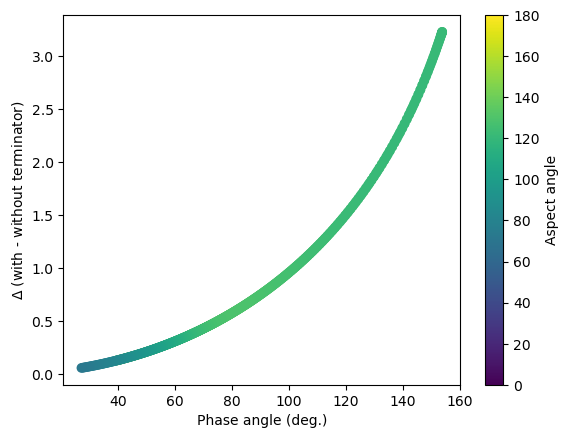

In [51]:
fig, ax = plt.subplots()

# --------------------------------------------------------------------------------
# Plot the difference between lightcurve with and without terminator
im = ax.scatter(
    observations_df["phase_deg"],
    observations_df["LCwT_HG1G2_mag"] - observations_df["LC_HG1G2_mag"],
    linestyle="-",
    c=Lambda,
    vmin=0, vmax=180
)

# --------------------------------------------------------------------------------
# Axes
fig.colorbar(im, label='Aspect angle')
ax.set_xlabel('Phase angle (deg.)')
ax.set_ylabel(r'$\Delta$ (with - without terminator)')

The difference between the two models is larger at larger phase angles, as expected.
It is also larger for equatorial views, when the apparent shape varies the most.

In [16]:

# Constants
au = 1.495978707e8  # AU in km
c = 299792.458  # speed of light in km/s
c_kmday = c * 86400  # speed of light in km/day


# Extract the relevant columns from the input DataFrame.
ep = df["fieldMJD_TAI"].values - df["Range_LTC_km"] / c_kmday
ra = np.radians(df["RA_deg"].values)
dec = np.radians(df["Dec_deg"].values)
phase = df['phase_deg'].values
ra_s = np.radians(df["RA_s_deg"].values)
dec_s = np.radians(df["Dec_s_deg"].values)
period = df["Period"].values
t0 = df["Time0"].values
phi0 = df["phi0"].values
alpha0 = df["RA0"].values
delta0 = df["Dec0"].values
a_b = df["a/b"].values
a_c = df["a/c"].values

# Rotation (in an inertial reference frame)
W = ellipsoidalwithterminator_lightcurve.rotation_phase(ep, phi0, 2 * np.pi / period, t0)

# Sub-observer angles
cos_aspect = ellipsoidalwithterminator_lightcurve.cos_aspect_angle(ra, dec, alpha0, delta0)
cos_aspect_2 = cos_aspect**2
sin_aspect_2 = 1 - cos_aspect_2
sin_aspect = np.sqrt(sin_aspect_2)
rot_phase = ellipsoidalwithterminator_lightcurve.subobserver_longitude(ra, dec, alpha0, delta0, W)

# Subsolar angles
cos_aspect_s = ellipsoidalwithterminator_lightcurve.cos_aspect_angle(ra_s, dec_s, alpha0, delta0)
cos_aspect_s_2 = cos_aspect_s**2
sin_aspect_s_2 = 1 - cos_aspect_s_2
sin_aspect_s = np.sqrt(sin_aspect_s_2)
rot_phase_s = ellipsoidalwithterminator_lightcurve.subobserver_longitude(ra_s, dec_s, alpha0, delta0, W)

# Sub-observer (e.TQe):
eQe = (
    sin_aspect_2 * (np.cos(rot_phase) ** 2 + (a_b**2) * np.sin(rot_phase) ** 2)
    + cos_aspect_2 * a_c**2
)

# Sub-Solar (s.TQs):
sQs = (
    sin_aspect_s_2 * (np.cos(rot_phase_s) ** 2 + (a_b**2) * np.sin(rot_phase_s) ** 2)
    + cos_aspect_s_2 * a_c**2
)

# Cross-term (e.TQs):
eQs = (
    sin_aspect * np.cos(rot_phase) * sin_aspect_s * np.cos(rot_phase_s)
    + sin_aspect * np.sin(rot_phase) * sin_aspect_s * np.sin(rot_phase_s) * (a_b**2)
    + cos_aspect * cos_aspect_s * a_c**2
)

# Integrated fulx is the sum of half-limb + half-terminator ellipses
I_tot = (np.sqrt(eQe) + eQs / np.sqrt(sQs)) / 2.
I_tot_s = (np.sqrt(eQe) + np.sign(90-phase) * eQs / np.sqrt(sQs)) / 2
f = -2.5 * np.log10(I_tot)
f_s = -2.5 * np.log10(I_tot_s)



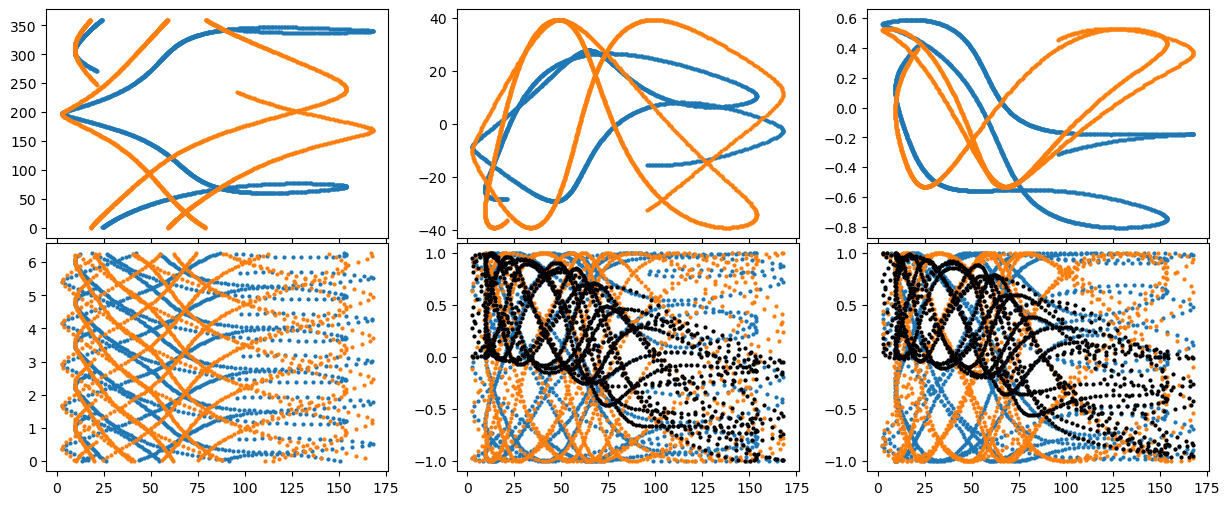

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15,6), sharex=True, gridspec_kw={'hspace':0.02})

ph = observations_df["phase_deg"]
axs = ax.flatten()
s = 4
axs[0].scatter( ph, observations_df.RA_deg,s=s)
axs[0].scatter( ph, observations_df.RA_s_deg,s=s)

axs[1].scatter( ph, observations_df.Dec_deg,s=s)
axs[1].scatter( ph, observations_df.Dec_s_deg,s=s)

axs[2].scatter( ph, cos_aspect,s=s)
axs[2].scatter( ph, cos_aspect_s,s=s)

axs[3].scatter( ph, rot_phase % (2*np.pi),s=s)
axs[3].scatter( ph, rot_phase_s % (2*np.pi),s=s)

axs[4].scatter( ph, np.cos(rot_phase),s=s)
axs[4].scatter( ph, np.cos(rot_phase_s),s=s)
axs[4].scatter( ph, np.cos(rot_phase)*np.cos(rot_phase_s),s=s, color='black')

axs[5].scatter( ph, np.sin(rot_phase),s=s)
axs[5].scatter( ph, np.sin(rot_phase_s),s=s)
axs[5].scatter( ph, np.sin(rot_phase)*np.sin(rot_phase_s),s=s, color='black')


In [18]:
observations_df

,fieldMJD_TAI,H_filter,G1,G2,RA_deg,Dec_deg,RA_s_deg,Dec_s_deg,Period,Time0,...,Dec0,a/b,a/c,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,HG1G2_mag,LC_HG1G2_mag,Delta_m,LCwT_HG1G2_mag
0,2461041.5,16.22,0.62,0.14,271.111363,-28.372767,247.741810,-36.478361,0.25,2461041.5,...,0.523599,1.0,1.0,2.132937e+08,7.364260e+07,21.255785,16.505400,16.505400,0.037573,16.542974
1,2461041.8,16.22,0.62,0.14,271.667637,-28.403977,248.814712,-36.713556,0.25,2461041.5,...,0.523599,1.0,1.0,2.136712e+08,7.380232e+07,20.908374,16.502241,16.502241,0.036348,16.538590
2,2461042.1,16.22,0.62,0.14,272.220467,-28.433440,249.889370,-36.938107,0.25,2461041.5,...,0.523599,1.0,1.0,2.140361e+08,7.396353e+07,20.562230,16.498929,16.498929,0.035148,16.534077
3,2461042.4,16.22,0.62,0.14,272.771054,-28.458249,250.965506,-37.152003,0.25,2461041.5,...,0.523599,1.0,1.0,2.144085e+08,7.412616e+07,20.219851,16.495752,16.495752,0.033981,16.529734
4,2461042.7,16.22,0.62,0.14,273.325601,-28.479814,252.042836,-37.355240,0.25,2461041.5,...,0.523599,1.0,1.0,2.147790e+08,7.429018e+07,19.885302,16.492757,16.492757,0.032861,16.525617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2461490.0,16.22,0.62,0.14,341.415792,-15.619830,230.566344,-31.130696,0.25,2461041.5,...,0.523599,1.0,1.0,1.205272e+08,7.124922e+07,98.870728,17.751733,17.751733,0.934413,18.686146
1496,2461490.3,16.22,0.62,0.14,341.619114,-15.604242,231.579196,-31.533056,0.25,2461041.5,...,0.523599,1.0,1.0,1.213420e+08,7.137819e+07,98.084304,17.738370,17.738370,0.917125,18.655494
1497,2461490.6,16.22,0.62,0.14,341.831765,-15.583462,232.596993,-31.925946,0.25,2461041.5,...,0.523599,1.0,1.0,1.221645e+08,7.150940e+07,97.311515,17.725844,17.725844,0.900368,18.626212
1498,2461490.9,16.22,0.62,0.14,342.049221,-15.560269,233.619627,-32.309248,0.25,2461041.5,...,0.523599,1.0,1.0,1.229738e+08,7.164278e+07,96.547247,17.713576,17.713576,0.884018,18.597594


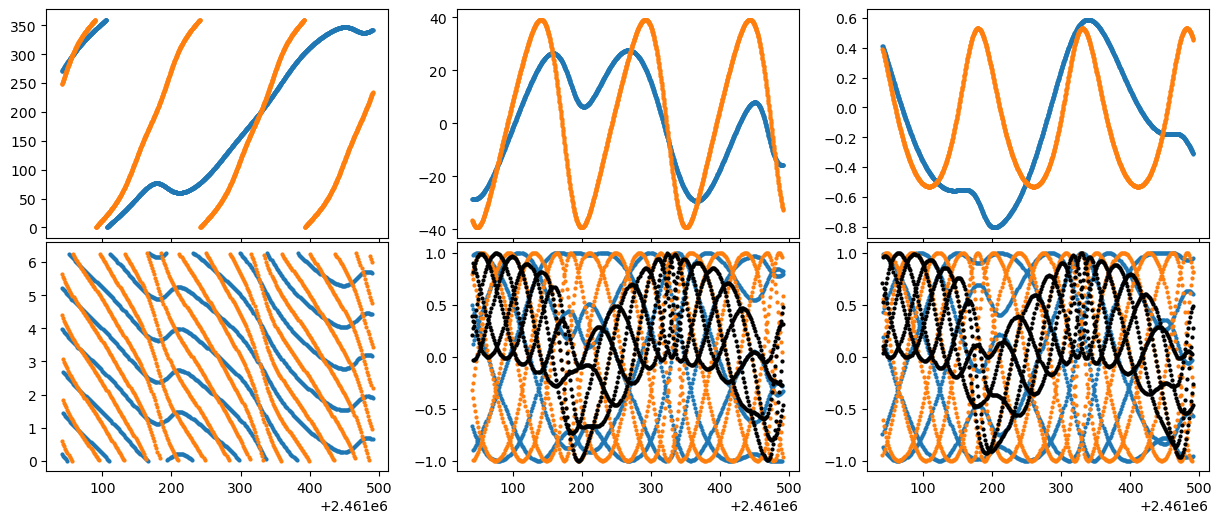

In [19]:
fig, ax = plt.subplots(2,3,figsize=(15,6), sharex=True, gridspec_kw={'hspace':0.02})

# ax.scatter(rot_phase, rot_phase_s)
# x = np.array( [rot_phase.min(), rot_phase.max()])
# ax.plot(x,x, color='orange')
axs=ax.flatten()
s = 4
axs[0].scatter( observations_df.fieldMJD_TAI, observations_df.RA_deg,s=s)
axs[0].scatter( observations_df.fieldMJD_TAI, observations_df.RA_s_deg,s=s)

axs[1].scatter( observations_df.fieldMJD_TAI, observations_df.Dec_deg,s=s)
axs[1].scatter( observations_df.fieldMJD_TAI, observations_df.Dec_s_deg,s=s)

axs[2].scatter( observations_df.fieldMJD_TAI, cos_aspect,s=s)
axs[2].scatter( observations_df.fieldMJD_TAI, cos_aspect_s,s=s)

axs[3].scatter( observations_df.fieldMJD_TAI, rot_phase % (2*np.pi),s=s)
axs[3].scatter( observations_df.fieldMJD_TAI, rot_phase_s % (2*np.pi),s=s)

axs[4].scatter( observations_df.fieldMJD_TAI, np.cos(rot_phase),s=s)
axs[4].scatter( observations_df.fieldMJD_TAI, np.cos(rot_phase_s),s=s)
axs[4].scatter( observations_df.fieldMJD_TAI, np.cos(rot_phase)*np.cos(rot_phase_s),s=s, color='black')

axs[5].scatter( observations_df.fieldMJD_TAI, np.sin(rot_phase),s=s)
axs[5].scatter( observations_df.fieldMJD_TAI, np.sin(rot_phase_s),s=s)
axs[5].scatter( observations_df.fieldMJD_TAI, np.sin(rot_phase)*np.sin(rot_phase_s),s=s, color='black')


Text(0, 0.5, '$\\Delta$ (with - without terminator)')

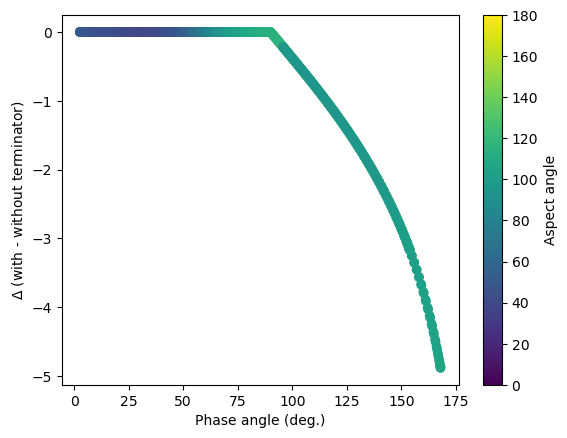

In [20]:
fig, ax = plt.subplots()

# --------------------------------------------------------------------------------
# Plot the difference between lightcurve with and without terminator
im = ax.scatter(
    observations_df["phase_deg"],
    f_s-f, 
    linestyle="-",
    c=Lambda,
    vmin=0, vmax=180
)

# --------------------------------------------------------------------------------
# Axes
fig.colorbar(im, label='Aspect angle')
ax.set_xlabel('Phase angle (deg.)')
ax.set_ylabel(r'$\Delta$ (with - without terminator)')